# 1. VK Social network analysis


## 1.1 Download your vk friends information 

1. You need to get access token, go here https://vk.com/dev and create stand alone application
    - Мои приложения
    - Создать приложение
    - Standalone


2. Access token можно найти в разделе Настройки вашего приложения, вам нужен тот который `Сервисный ключ доступа`

3. List of api methods https://vk.com/dev/methods
4. We will mainly use `friends.get` and `users.get`

In [1]:
import json
import requests

In [2]:
def get_friends_info(user_id, access_token, fields=None):
    if fields is None:
        fields = 'sex'
    api = 'https://api.vk.com/method/'
    friends_url = f'{api}friends.get?fields={fields}&user_id={user_id}&access_token={access_token}&v=5.21'

    json_response = requests.get(friends_url).json()
    if json_response.get('error'):
        raise KeyError(f'Inable to access {user_id} friends.')

    return json_response[u'response'], friends_url

### Example

In [3]:
user_id = 11986950
fields = 'sex,city,education,bdate' # check https://vk.com/dev/users.get for all possible fields values
access_token = 'fc892c50fc892c50fc892c5001fce4048dffc89fc892c50a3f102825ce08210ad957445' # put your token


mates, url = get_friends_info(user_id, access_token, fields)

In [4]:
mates.keys()

dict_keys(['count', 'items'])

In [5]:
mates['count']

83

In [6]:
len(mates['items'])

83

In [7]:
mates['items'][0]

{'id': 409037,
 'first_name': 'Olga',
 'last_name': 'Podolskaya',
 'sex': 1,
 'bdate': '27.10',
 'track_code': '60e6414bo7GBXQUdY1QV4t0bp3eQ5vuAxAd9SEZWexMRu0c1GKrO2tltZh0xDBCz6tp0-mCPjJS2bg'}

## 1.2 Build an egocentric graph



Вам нужно самостоятельно написать функцию, которая из списка ваших друзей и их друзей построит такую сеть, что:
- каждая вершина в ней - ваш друг
- ребро между двумя друзьями возникает только в случае если они друг у друга в друзьях

Дополнительную информацию в принципе вытаскивать не обязательно, но вам может быть интересно посмотреть повышает ли одинаковый пол/возраст/школа вероятность быть друг у друга в друзьях или нет. Это называется **homophily** https://en.wikipedia.org/wiki/Network_homophily 

> Поскольку вам нужно будет запустить `get_friends_info` столько раз сколько у вас друзей, это может занять какое-то время, и после обработки информацию о графе лучше сохранить.

Хранить такой граф удобно ввиде списка ребер, то есть таблицы с двумя колонками:

| Вершина 1 | Вершина 2 |
|---|---|
|user_id_1| user_id_2|
|user_id_1| user_id_3|
|user_id_2| user_id_3|

Информацию о пользователях удобно хранить в отдельной таблице:

| User id | Name | Sex | Birthday |
|---|---|---|---|
|user_id_1| Anastasia | Female | 01.02.2003 |
|user_id_2| Alex |Male| 21.01.1999|
|user_id_3| Yulia|Female| 06.05.2001|


### Networkx examples

In [8]:
import networkx as nx
import pandas as pd
import numpy as np

In [9]:
edges = [
    (1, 2),
    (1, 3),
    (2, 3),
    (4, 5),
    (4, 6),
    (5, 6),
    (1, 4),
]
df_edges = pd.DataFrame(data=edges, columns=['source', 'target'])

In [10]:
G = nx.from_pandas_edgelist(df_edges)

In [11]:
G.is_directed()

False

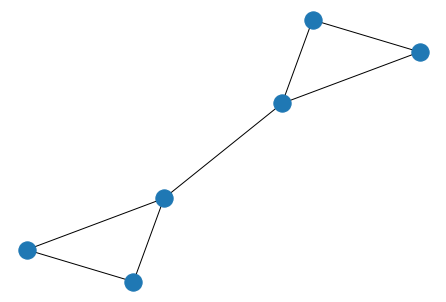

In [12]:
nx.draw(G)

In [13]:
np.array(nx.adjacency_matrix(G).todense())

array([[0, 1, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0]])

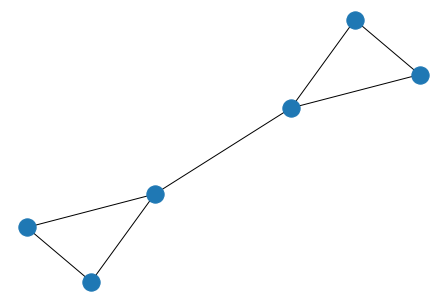

In [14]:
pos = nx.layout.fruchterman_reingold_layout(G)
nx.draw(G, pos=pos)

In [15]:
nx.centrality.betweenness_centrality(G)

{1: 0.6000000000000001, 2: 0.0, 3: 0.0, 4: 0.6000000000000001, 5: 0.0, 6: 0.0}

In [16]:
nx.centrality.closeness_centrality(G)

{1: 0.7142857142857143, 2: 0.5, 3: 0.5, 4: 0.7142857142857143, 5: 0.5, 6: 0.5}

In [17]:
# with edge weight and 

edges = [
    (1, 2, 5, 'siblings'),
    (1, 3, 2, 'friends'),
    (2, 3, 1, 'friends'),
    (4, 5, 3, 'spouses'),
    (4, 6, 2),
    (5, 6, 3),
    (1, 4, 1),
]
df_edges = pd.DataFrame(data=edges, columns=['source', 'target', 'weight', 'relation'])

G = nx.from_pandas_edgelist(df_edges, edge_attr=['weight', 'relation'])


edges = [
    (1, 2),
    (1, 3),
    (2, 3),

]
df_edges = pd.DataFrame(data=edges, columns=['source', 'target'])

In [18]:
G.get_edge_data(4,5)

{'weight': 3, 'relation': 'spouses'}

In [19]:
# !pip install python-louvain
# https://github.com/taynaud/python-louvain

from community import best_partition

In [20]:
c = best_partition(G, weight='weight')
print(c)

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}


### More examples https://networkx.github.io/documentation/stable/auto_examples/index.html

## 1.3 Analyse the resulting egocentric network


1. Analyse simple network properties: #vertices, #edges, #connected components.
2. Plot nodes degree distribution, does power law hold for your network?
3. Compute centrality measures for your network: degree, closeness, betweenness, eigenvector; interpret the ranking results.
4. Using different layouts plot you network, use different node characteristics as node size/color. You could also download meta data to use it for node coloring: gender, age, city, etc.
5. (optional) Find network communities using either igraph or community package, analyse the results.

# 2. Random graphs models

Имплементируйте модели случайных графов.

- Preferential attachement (to model power law distr.)
- Configuration model (to model degree sequence)
- Stochastic-block model (to model community structure)

Compare different model with your own network (using different characteristics), which model describe your network best?



# 3. Отправка решения.


1. Прогоните свой jupyter notebook: **Kernel** $\rightarrow$ **Restart & Run all**, нотбук **должен** запускаться линейно!
2. Удалите всю персональную информацию (замените access_token на пустую строку, удалите напечатанные pandas таблицы с метаданными и пр.)
3. Назовите нотбук `Имя_Фамилия_HA1_networks_2020`, например `Anvar_Kurmukov_HA1_networks_2020`
4. Сохраните нотбук в формате `html` и в формате `ipython`
5. Отправьте эти два файла на почту kurmukovai@gmail.com с темой письма `Имя_Фамилия_HA1_networks_2020`.

---

## Комментарии к решению и выставлению оценки.
Ваш файл с решением должно быть **комфортно читать**:
- **комментируйте** происходящее, лучше всего для этого подходит markdown cells, но можно и в комментариях в ячейках с кодом. Под комментируйте имеется ввиду написание выводов на естественном языке доступном проверяющему (русский или английский), *например* вы напечатали список друзей отранжированных по какой-то центральности, прокоментируйте результат: кто оказался в топе, почему именно он/она?
- не нужно оставлять в нем все 100500 графиков которые вы рисовали пока решали дз, оставьте только те которые иллюстрируют самое главное
- не нужно оставлять все отладочные ячейки нотбука, сохраните свою работу отдельно, а в файле которые отправляете в качестве решения оставьте только нужное
- перед прогоном уберите циклы с принтами 999 строк с какой-то информацией, *например* если вы хотите показать вершины с наибольшим значением какой-нибудь центральности, напечатайте первые 5-10, не надо печатать для всех ваших друзей
- округляйте значения характеристик до нескольких значащих цифр (столько сколько целесообразно в каждом отдельном случае), *например* число 0.3249732, целесообразно округлить до 0.325, но если его надо сравнивать с числом 0.3249610, то до 0.324973